In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import copy


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "./train"
val_dir = "./val"
test_dir = "./test"
batch_size = 32
num_classes = 5
epochs = 20
patience = 3
save_path = "../modals/best_model_layer3.pth"

In [4]:
# Data Augmentation and Normalization
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Load datasets
train_data = datasets.ImageFolder("../data/train", transform=train_transforms)
val_data = datasets.ImageFolder("../data/val", transform=val_test_transforms)
test_data = datasets.ImageFolder("../data/test", transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [7]:

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last block (layer4) + fully connected layer
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Replace FC layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

model = model.to(device)

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

In [9]:
# ==== TRAINING FUNCTION ====
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=epochs, patience=patience):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improve = 0

    for epoch in range(num_epochs):
        print(f"\n\U0001F31F Epoch {epoch+1}/{num_epochs}")

        # === TRAIN ===
        model.train()
        running_loss, running_corrects = 0.0, 0
        train_loop = tqdm(train_loader, desc="\u2705 Training", leave=False)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"\u2705 Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")

        # === VALIDATION ===
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"\U0001F9EA Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # Scheduler step
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"\U0001F53D Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print("Saving best model...")
            no_improve = 0
        else:
            no_improve += 1
            print(f"No improvement for {no_improve} epoch(s)")

        # Early stopping
        if no_improve >= patience:
            print("\u26d4 Early stopping triggered!")
            break

    model.load_state_dict(best_model_wts)
    print(f"Best model saved to {save_path} with accuracy: {best_acc:.4f}")
    return model
print(f"{save_path}", epochs, patience)


../modals/best_model_layer3.pth 20 3


In [10]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=epochs, patience=patience)


🌟 Epoch 1/20


✅ Train Loss: 0.6914 | Train Acc: 0.7283
🧪 Val Loss:   0.3694 | Val Acc:   0.8507
Saving best model...

🌟 Epoch 2/20


✅ Train Loss: 0.4758 | Train Acc: 0.8097
🧪 Val Loss:   0.3769 | Val Acc:   0.8408
No improvement for 1 epoch(s)

🌟 Epoch 3/20


✅ Train Loss: 0.4273 | Train Acc: 0.8360
🧪 Val Loss:   0.3411 | Val Acc:   0.8601
Saving best model...

🌟 Epoch 4/20


✅ Train Loss: 0.3936 | Train Acc: 0.8459
🧪 Val Loss:   0.3571 | Val Acc:   0.8646
Saving best model...

🌟 Epoch 5/20


✅ Train Loss: 0.3816 | Train Acc: 0.8462
🧪 Val Loss:   0.3560 | Val Acc:   0.8720
Saving best model...

🌟 Epoch 6/20


✅ Train Loss: 0.3689 | Train Acc: 0.8517
🧪 Val Loss:   0.3594 | Val Acc:   0.8487
🔽 Learning rate reduced: 0.000400 → 0.000200
No improvement for 1 epoch(s)

🌟 Epoch 7/20


✅ Train Loss: 0.3311 | Train Acc: 0.8659
🧪 Val Loss:   0.2724 | Val Acc:   0.8834
Saving best model...

🌟 Epoch 8/20


✅ Train Loss: 0.3174 | Train Acc: 0.8720
🧪 Val Loss:   0.2663 | Val Acc:   0.8929
Saving best model...

🌟 Epoch 9/20


✅ Train Loss: 0.3120 | Train Acc: 0.8745
🧪 Val Loss:   0.2749 | Val Acc:   0.8904
No improvement for 1 epoch(s)

🌟 Epoch 10/20


✅ Train Loss: 0.3062 | Train Acc: 0.8786
🧪 Val Loss:   0.2682 | Val Acc:   0.8894
No improvement for 2 epoch(s)

🌟 Epoch 11/20


✅ Train Loss: 0.3035 | Train Acc: 0.8746
🧪 Val Loss:   0.3001 | Val Acc:   0.8824
🔽 Learning rate reduced: 0.000200 → 0.000100
No improvement for 3 epoch(s)
⛔ Early stopping triggered!
Best model saved to ../modals/best_model_layer3.pth with accuracy: 0.8929


In [12]:
# Load the model
import torch
import torch.nn as nn
from torchvision import models

num_classes = 5  # or your actual number
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== MODEL ====
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Replace FC layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

model = model.to(device)

# Load trained weights
model.load_state_dict(torch.load("../modals/best_model.pth", weights_only=True))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# ==== TESTING ====
import torch
import numpy as np

all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

In [14]:
# Calculate accuracy
accuracy = np.sum(all_preds == all_labels) / len(all_labels) * 100
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 89.48%


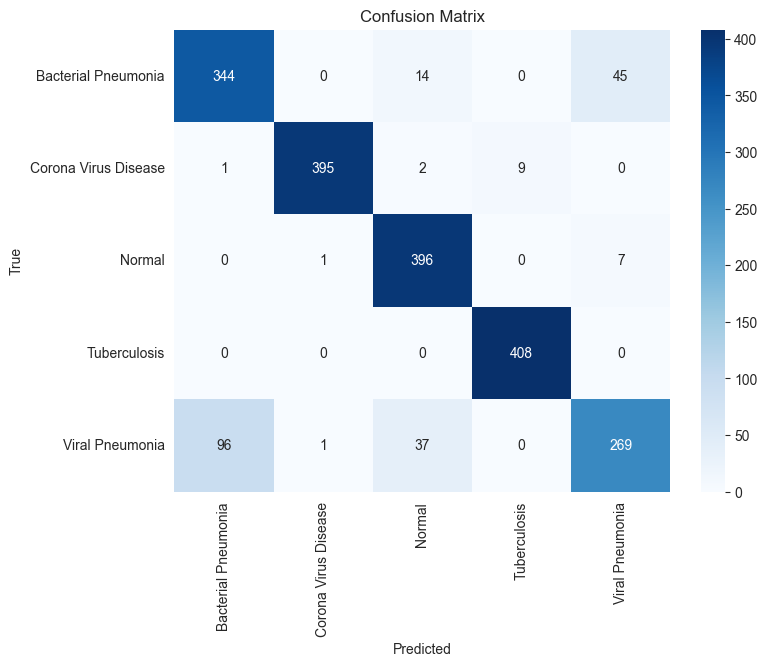

Classification Report:

                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.78      0.85      0.82       403
Corona Virus Disease       0.99      0.97      0.98       407
              Normal       0.88      0.98      0.93       404
        Tuberculosis       0.98      1.00      0.99       408
     Viral Pneumonia       0.84      0.67      0.74       403

            accuracy                           0.89      2025
           macro avg       0.89      0.89      0.89      2025
        weighted avg       0.90      0.89      0.89      2025



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class_names = test_data.classes

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


<Figure size 1000x800 with 0 Axes>

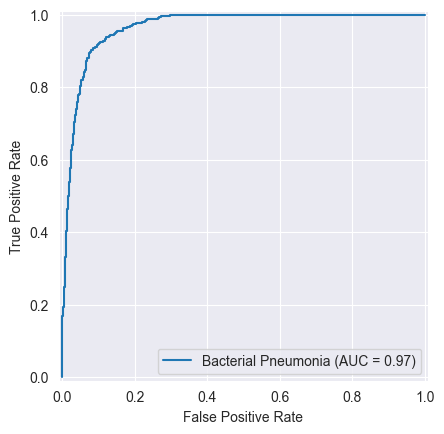

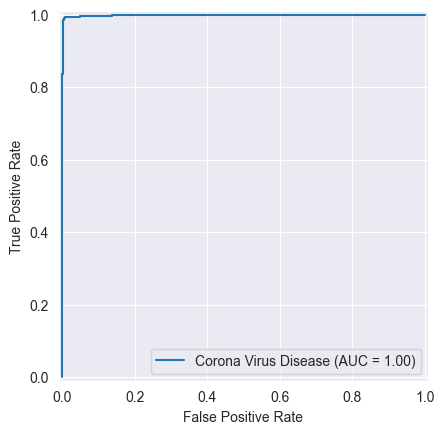

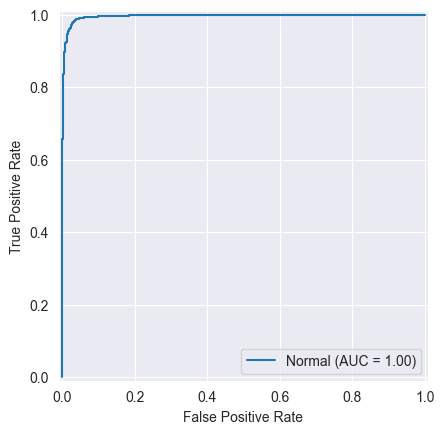

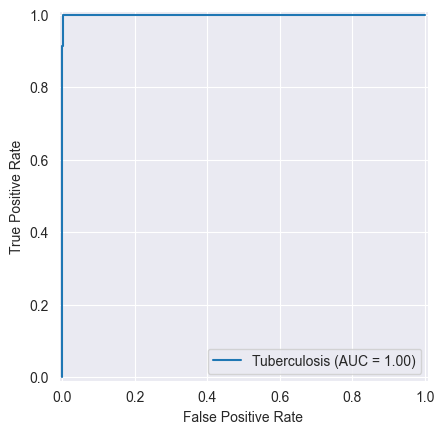

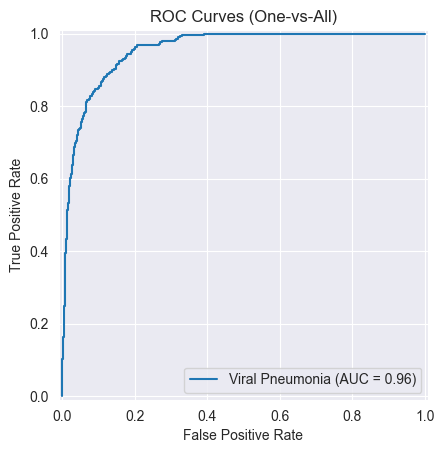

In [17]:
# Plot ROC curve for each class
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

n_classes = num_classes
y_true_bin = label_binarize(all_labels, classes=range(n_classes))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=class_names[i]).plot()

plt.title("ROC Curves (One-vs-All)")
plt.grid(True)
plt.show()

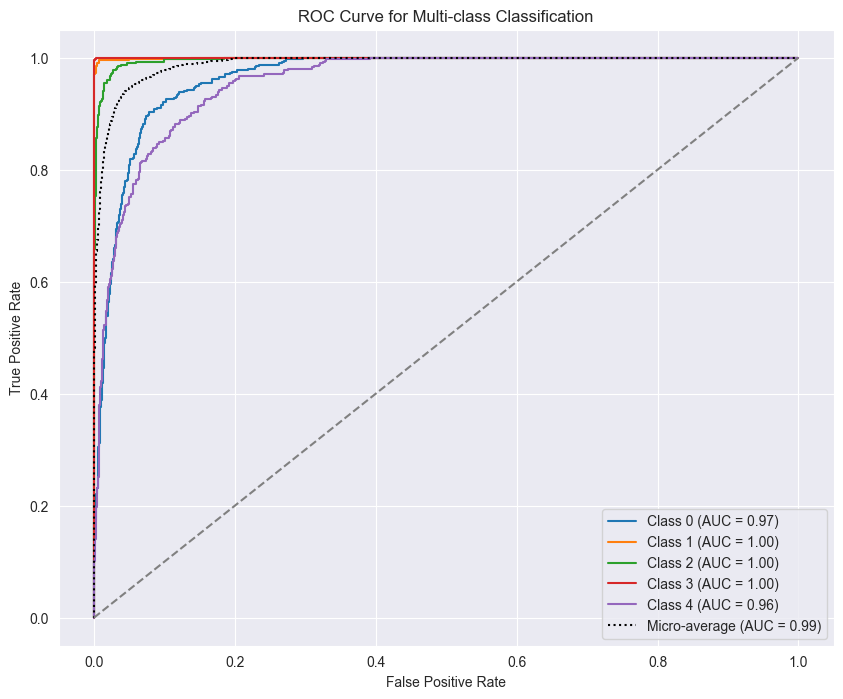

In [18]:
# Plot ROC curve for multi-class classification
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC curve
n_classes = len(np.unique(all_labels))  # Number of classes
y_true = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])  # Update with the correct class labels
y_score = all_probs  # These are the probabilities for each class

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot each class ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle=':', color='black')

# Plot the diagonal line (no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.title('ROC Curve for Multi-class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
